In [ ]:

%pip install -qU langchain langchain-openai langchain-community langgraph langchain-mcp-adapters mcp chromadb tiktoken bs4

In [4]:
# 환경 변수 설정
import os
from dotenv import load_dotenv

load_dotenv()

# OpenAI API 키 설정 (환경 변수에 없으면 직접 입력)
if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = "your-openai-api-key"

In [16]:
# 문서 로드 및 벡터 스토어 생성
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# 임베딩 모델 설정
embeddings = OpenAIEmbeddings()

# PDF 파일 경로 설정 (OpenAI RAG 실습과 동일한 문서 사용)
file_path = "docs/DeepSeek_OCR_paper.pdf"

# PDF 로더 초기화 및 문서 로드
loader = PyPDFLoader(file_path)
docs = loader.load()

print(f"📄 로드된 문서 수: {len(docs)} 페이지")

# 문서 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, 
    chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs)

print(f"총 {len(doc_splits)}개의 문서 청크 생성됨")

# 벡터 스토어 생성
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)

# 리트리버 생성
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})


📄 로드된 문서 수: 22 페이지
총 46개의 문서 청크 생성됨


In [24]:
# RAG 체인 설정
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# LLM 모델 설정
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

# RAG 프롬프트 가져오기

prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. 
     Use three sentences maximum and keep the answer concise. Answer in Korean"""),
    ("human", "Question: {question}\n\nContext: {context}\n\nAnswer:")
])

# 문서 포맷팅 함수
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# RAG 체인 생성
rag_chain = prompt | llm | StrOutputParser()


In [25]:
# LangGraph 상태 정의
from typing import TypedDict, List, Annotated
from langchain_core.documents import Document
import operator

class GraphState(TypedDict):
    """RAG 그래프의 상태를 정의"""
    question: str
    documents: List[Document]
    generation: str


In [26]:

# 그래프 노드 함수 정의
def retrieve(state: GraphState) -> GraphState:
    """문서 검색 노드"""
    print("---RETRIEVE---")
    question = state["question"]
    
    # 리트리버를 사용해 관련 문서 검색
    documents = retriever.invoke(question)
    
    return {"question": question, "documents": documents, "generation": ""}


def generate(state: GraphState) -> GraphState:
    """답변 생성 노드"""
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # 문서를 텍스트로 포맷팅
    docs_txt = format_docs(documents)
    
    # RAG 체인을 사용해 답변 생성
    generation = rag_chain.invoke({"context": docs_txt, "question": question})
    
    return {"question": question, "documents": documents, "generation": generation}

In [27]:

# LangGraph 그래프 생성 및 컴파일
from langgraph.graph import StateGraph, START, END

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)

# 엣지 연결
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# 그래프 컴파일
app = workflow.compile()

print("RAG 그래프가 성공적으로 컴파일되었습니다.")

RAG 그래프가 성공적으로 컴파일되었습니다.


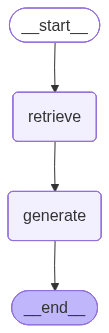

In [28]:
# 그래프 시각화
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"시각화 오류: {e}")
    print("그래프 구조: START -> retrieve -> generate -> END")

In [29]:
# RAG 그래프 실행 테스트
question = "Deepseek OCR이 뭐야?"

# 그래프 실행
result = app.invoke({"question": question})

print("=" * 50)
print(f"질문: {result['question']}")
print("=" * 50)
print(f"\n답변:\n{result['generation']}")
print("=" * 50)
print(f"\n참조 문서 수: {len(result['documents'])}")

---RETRIEVE---
---GENERATE---
질문: Deepseek OCR이 뭐야?

답변:
DeepSeek OCR은 대규모 사전학습 데이터 생산이 가능한 실용적인 OCR 모델로, 약 100개 언어의 문서 처리를 지원합니다. 이 모델은 높은 정확도와 적은 비전 토큰 수로 최첨단 성능을 보여주며, LLM(대형 언어 모델)의 필수 보조 도구로 활용됩니다. 또한, 일반 이미지 이해 능력도 일부 갖추고 있습니다.

참조 문서 수: 3


In [31]:
# 스트리밍 방식으로 실행
question = "Omnidoc bench 결과는 어때?"

print(f"질문: {question}\n")
print("=" * 50)

for output in app.stream({"question": question}):
    for node_name, value in output.items():
        print(f"\n[{node_name}] 노드 실행 완료")
        if node_name == "generate" and "generation" in value:
            print(f"\n답변:\n{value['generation']}")


질문: Omnidoc bench 결과는 어때?

---RETRIEVE---

[retrieve] 노드 실행 완료
---GENERATE---

[generate] 노드 실행 완료

답변:
OmniDocBench 결과에서 DeepSeek-OCR은 100개의 비전 토큰만으로도 GOT-OCR2.0(256 토큰 사용)을 능가하며, 400 토큰(285 유효 토큰) 시에는 최첨단 성능과 동등한 결과를 보였습니다. 또한, DeepSeek-OCR은 적은 비전 토큰 수로도 높은 정확도(편집 거리 ED < 0.25)를 달성하여 효율성과 성능을 모두 갖춘 모델임을 입증했습니다. 전반적으로 OmniDocBench에서 DeepSeek-OCR은 최상위 성능을 보이며 실용적임을 확인할 수 있습니다.


In [ ]:
# 벡터 스토어 정리 (선택사항)
# vectorstore.delete_collection()
# print("벡터 스토어가 삭제되었습니다.")
